# Riskfolio-Lib Tutorial: 
<br>__[Financionerioncios](https://financioneroncios.wordpress.com)__
<br>__[Orenji](https://www.orenj-i.net)__
<br>__[Riskfolio-Lib](https://riskfolio-lib.readthedocs.io/en/latest/)__
<br>__[Dany Cajas](https://www.linkedin.com/in/dany-cajas/)__
<a href='https://ko-fi.com/B0B833SXD' target='_blank'><img height='36' style='border:0px;height:36px;' src='https://cdn.ko-fi.com/cdn/kofi1.png?v=2' border='0' alt='Buy Me a Coffee at ko-fi.com' /></a> 

## Tutorial 35: Gini Mean Difference (GMD) Optimization

## 1. Downloading the data:

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

# Date range
start = '2016-01-01'
end = '2019-12-30'

start = '2016-01-01'
end = '2024-03-19'

# Tickers of assets
assets = ['JCI', 'TGT', 'CMCSA', 'CPB', 'MO', 'APA', 'MMC', 'JPM',
          'ZION', 'PSA', 'BAX', 'BMY', 'LUV', 'PCAR', 'TXT', 'TMO',
          'DE', 'MSFT', 'HPQ', 'SEE', 'VZ', 'CNP', 'NI', 'T', 'BA']

assets = ['NVDA', 'SMCI', 'KNSL', 'PDD', 'CRWD', 'AVGO']


assets.sort()

# Downloading data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data = data.resample('M').last()

data.columns = assets

[*********************100%%**********************]  25 of 25 completed


In [2]:
# Calculating returns

Y = data[assets].iloc[-300:,:].pct_change().dropna()

display(Y.head())

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2016-02-29,-10.0141%,-0.7129%,7.9508%,-0.3700%,3.6259%,5.7266%,9.4664%,4.1164%,10.0927%,2.2972%,...,2.9802%,5.4599%,-1.6051%,12.8300%,2.4681%,9.2253%,-2.1733%,-0.2045%,1.5209%,-5.7270%
2016-03-31,27.5078%,7.4124%,4.2736%,3.7630%,5.8029%,12.2920%,3.3037%,-3.2546%,16.5405%,4.3491%,...,9.6834%,6.1942%,11.2942%,5.2810%,6.0081%,4.8821%,9.7175%,6.8300%,6.6036%,13.5554%
2016-04-30,11.9613%,6.1919%,7.6436%,12.9931%,-0.0798%,2.5335%,-2.7912%,9.2480%,-0.4059%,5.5194%,...,-2.9328%,7.7161%,-11.2460%,-1.3539%,0.7401%,-3.3787%,1.8787%,6.0888%,-4.8120%,13.6721%
2016-05-31,5.0368%,-5.6536%,-2.3971%,-0.6650%,4.1804%,6.2808%,-1.8474%,-2.1639%,9.0465%,10.6438%,...,5.0639%,-4.9640%,3.6355%,-1.9426%,0.8501%,-12.8235%,5.2131%,-1.6029%,-0.0785%,2.0502%
2016-06-30,-2.5727%,2.9489%,5.0895%,3.1244%,2.9858%,6.5247%,9.8399%,-0.7802%,-5.3337%,-0.0469%,...,11.1484%,-6.9596%,1.4966%,-0.6698%,10.3704%,1.5121%,-2.5459%,-3.8930%,9.7053%,-10.3141%


## 2. Estimating Mean GMD Portfolios

The GMD model was proposed by __[Yitzhaki (1982)](https://www.researchgate.net/publication/4900733_Stochastic_Dominance_Mean_Variance_and_Gini%27s_Mean_Difference)__, but this model didn't gain popularity among practitioners due to the difficulty to solve it because it number of variables and constraints increases in proportion to $T(T-1)/2$ where $T$ is the number of observations. However, __[Cajas (2021)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3988927)__ proposed an alternative reformulation based on the ordered weighted averaging (OWA) operator optimization model for monotonic weights proposed by __[Chassein and Goerigk (2015)](https://kluedo.ub.uni-kl.de/frontdoor/deliver/index/docId/3899/file/paper.pdf)__. This formulation its the implemented in Riskfolio-Lib because is more efficient.

It is recommended to use MOSEK to optimize GMD, due to it requires more computing power for the number of constraints and variables the model use.

Instructions to install MOSEK are in this __[link](https://docs.mosek.com/9.2/install/installation.html)__, is better to install using Anaconda. Also you will need a license, I recommend you that ask for an academic license __[here](https://www.mosek.com/products/academic-licenses/)__.

### 2.1 Calculating the portfolio that optimize return/GMD ratio.

In [3]:
import riskfolio as rp
import mosek

# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimum portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

# port.solvers = ['MOSEK'] # It is recommended to use mosek when optimizing GMD
# port.sol_params = {'MOSEK': {'mosek_params': {mosek.iparam.num_threads: 2}}}

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'GMD' # Risk measure used, this time will be GMD
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
weights,0.0000%,4.0817%,9.2016%,0.0000%,0.0000%,8.5405%,0.0000%,0.0000%,0.0000%,0.0000%,...,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,3.2696%,0.0000%,0.0000%,0.0000%,0.0000%


### 2.2 Plotting portfolio composition

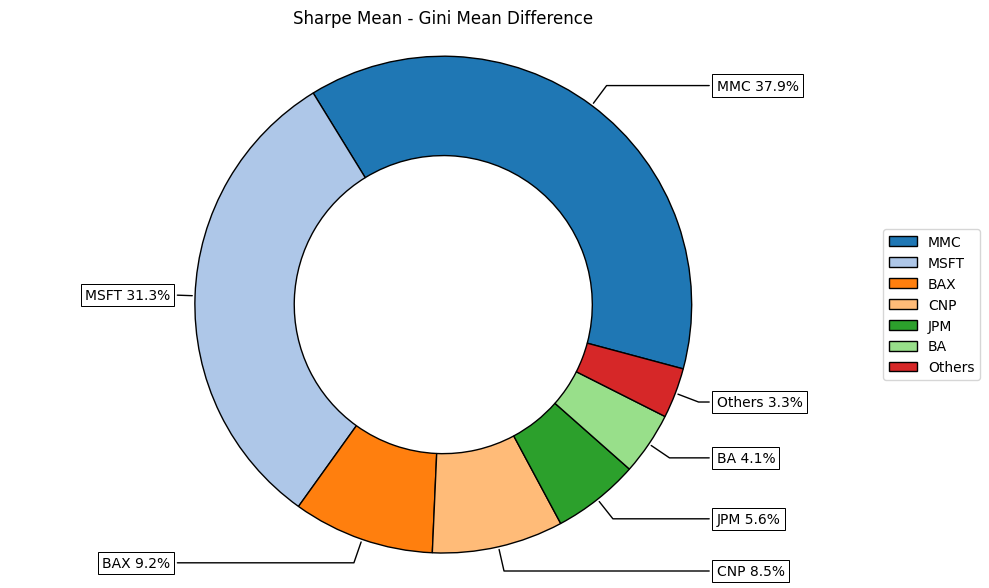

In [4]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w, title='Sharpe Mean - Gini Mean Difference', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

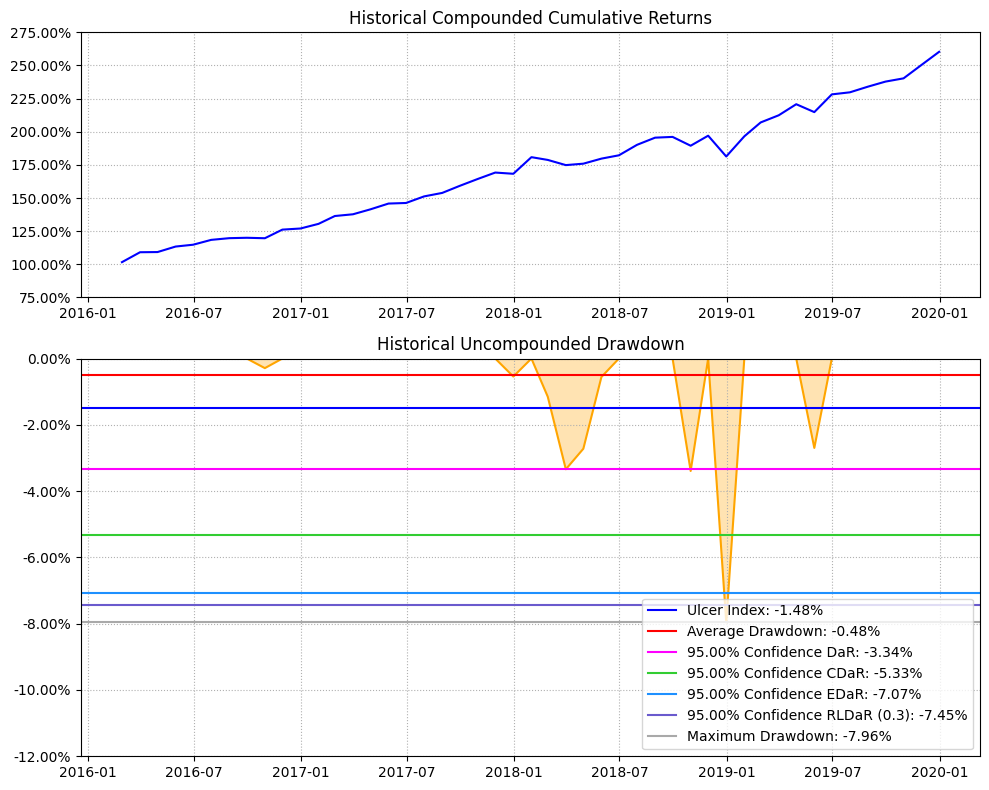

In [5]:
ax = rp.plot_drawdown(returns=Y,
                      w=w,
                      alpha=0.05,
                      height=8,
                      width=10,
                      height_ratios=[2, 3],
                      ax=None)

### 2.3 Calculate efficient frontier

In [6]:
points = 40 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
0,0.0000%,2.6092%,3.7509%,0.0000%,0.0000%,6.8325%,0.0000%,0.0000%,0.0000%,0.0000%,...,9.9918%,2.8357%,17.8318%,0.0000%,0.0000%,4.1806%,0.0000%,0.0000%,0.0000%,0.0000%
1,0.0000%,2.5975%,5.9277%,0.0000%,0.0000%,9.7445%,0.0000%,0.0000%,0.0000%,0.0000%,...,5.0282%,0.0000%,6.3158%,0.0000%,0.0000%,4.5820%,0.0000%,0.0000%,0.0000%,0.0000%
2,0.0000%,3.0536%,7.6951%,0.0000%,0.0000%,9.9460%,0.0000%,0.0000%,0.0000%,0.0000%,...,3.2427%,0.0000%,1.6155%,0.0000%,0.0000%,4.3616%,0.0000%,0.0000%,0.0000%,0.0000%
3,0.0000%,3.5208%,9.0930%,0.0000%,0.0000%,9.8389%,0.0000%,0.0000%,0.0000%,0.0000%,...,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,3.8557%,0.0000%,0.0000%,0.0000%,0.0000%
4,0.0000%,6.0780%,9.3517%,0.0000%,0.0000%,3.6275%,0.0000%,0.0000%,0.0000%,0.0000%,...,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,1.1740%,0.0000%,0.0000%,0.0000%,0.0000%


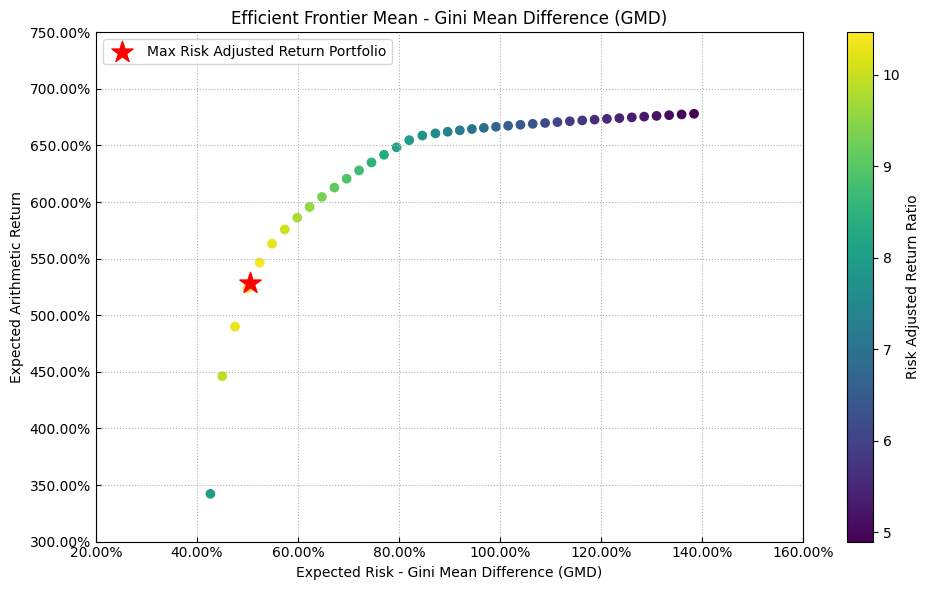

In [7]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

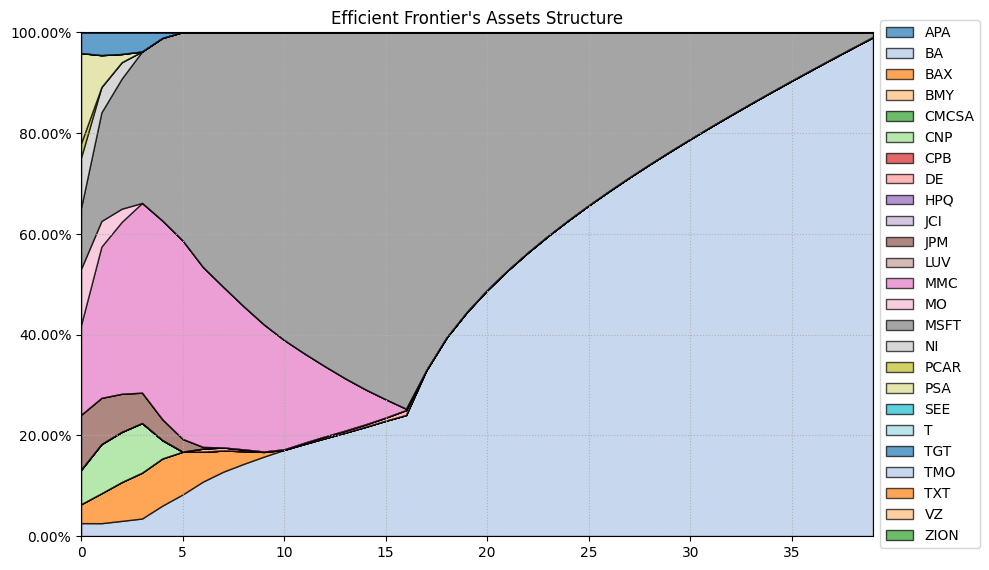

In [8]:
# Plotting efficient frontier composition

ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

## 3. Estimating Risk Parity Portfolios for GMD

### 3.1 Calculating the risk parity portfolio for GMD.

In [9]:
b = None # Risk contribution constraints vector

w_rp = port.rp_optimization(model=model, rm=rm, rf=rf, b=b, hist=hist)

display(w_rp.T)

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
weights,1.5876%,3.3322%,4.0537%,3.3252%,3.1430%,4.4089%,2.8671%,3.0681%,3.2621%,4.0064%,...,6.7824%,2.9271%,8.6834%,3.5525%,3.4706%,4.1439%,3.4943%,2.4895%,4.2076%,2.9537%


### 3.2 Plotting portfolio composition

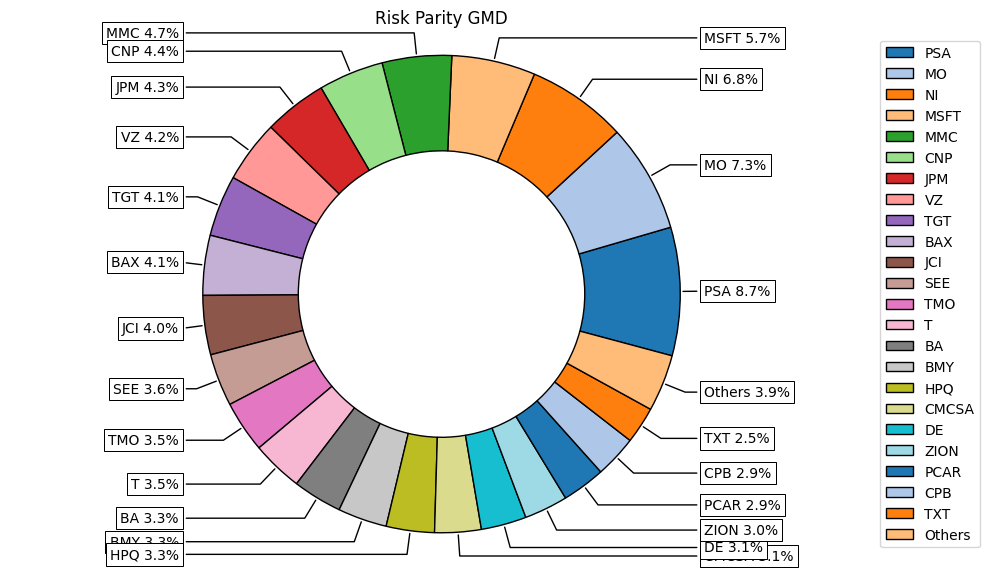

In [10]:
ax = rp.plot_pie(w=w_rp, title='Risk Parity GMD', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

### 3.3 Plotting Risk Composition

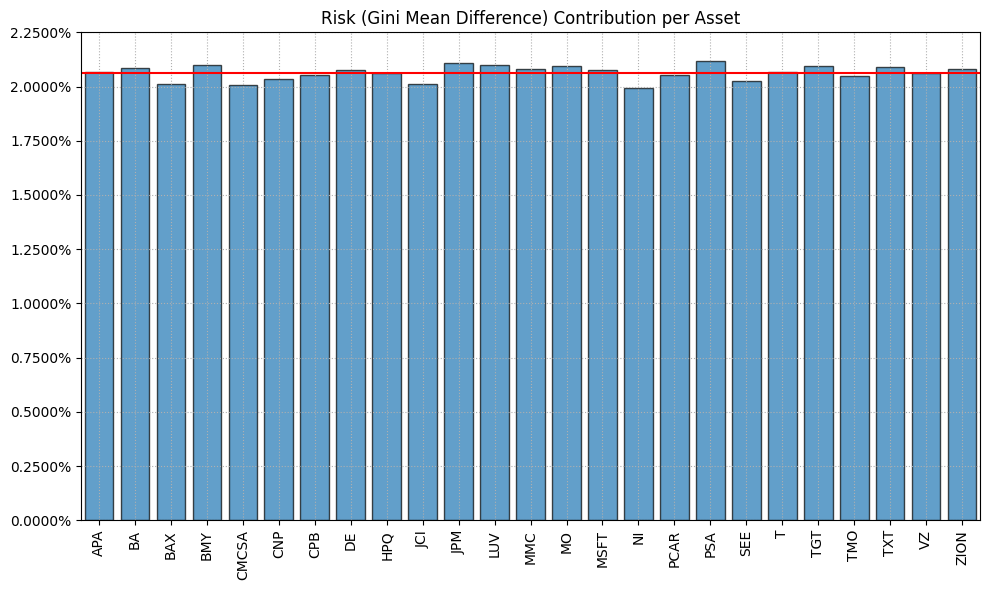

In [11]:
ax = rp.plot_risk_con(w_rp, cov=port.cov, returns=port.returns, rm=rm, rf=0, alpha=0.05,
                      color="tab:blue", height=6, width=10, ax=None)

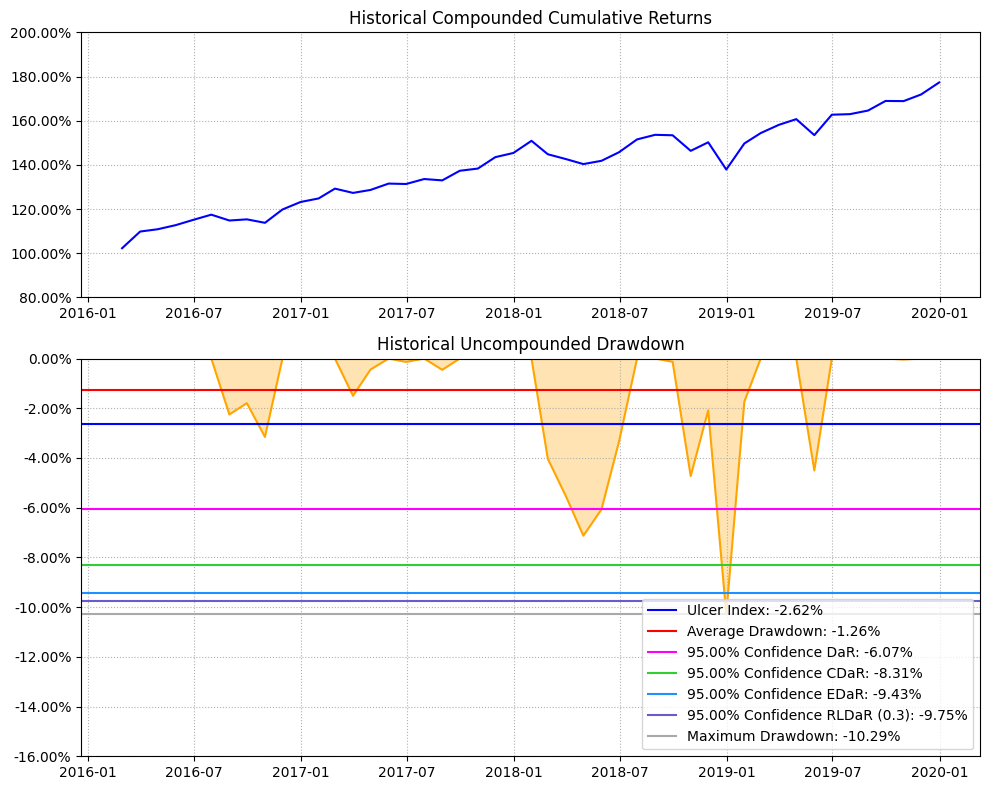

In [12]:
ax = rp.plot_drawdown(returns=Y,
                      w=w_rp,
                      alpha=0.05,
                      height=8,
                      width=10,
                      height_ratios=[2, 3],
                      ax=None)